<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_with_autoenc_0_91429.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [ ]:
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from google.colab import drive
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import gc

Loading kaggle datasets

In [ ]:

os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

 70% 41.0M/58.3M [00:00<00:00, 35.9MB/s]
100% 58.3M/58.3M [00:01<00:00, 57.4MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 218MB/s]
 79% 41.0M/52.2M [00:00<00:00, 27.8MB/s]
100% 52.2M/52.2M [00:00<00:00, 56.6MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 207MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 69.5MB/s]


loading drive

In [ ]:

drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Mounted at /content/gdrive


Loading dataframes

In [ ]:
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test.csv',index_col=[0])
trn=trn.drop(['id'],1)
tst=tst.drop(['id'],1)
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,isna_sum,dist1_isna,dist2_isna,D1_isna,D2_isna,D3_isna,D4_isna,D5_isna,D6_isna,D7_isna,D8_isna,D9_isna,D10_isna,D11_isna,D12_isna,D13_isna,D14_isna,D15_isna,V1_isna,id,isFraud
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,-0.752856,-0.429362,0.155508,0.000000,0.312997,0.0,0.000000,0.0,0.0,0.0,0.0,-0.012922,-0.737091,0.0,0.0,0.0,-0.807711,0.00739,-0.167776,0,1,0,1,0,1,1,1,1,1,1,0,0,1,1,1,0,0,1.01.0nan315.013926-13.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,-0.752856,-0.429362,-0.942090,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-1.038619,0.000000,0.0,0.0,0.0,-0.807711,0.00000,1.349188,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1.01.0gmail.com325.027551.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,-0.752856,-0.429362,-0.942090,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-1.038619,1.132473,0.0,0.0,0.0,0.746105,0.00739,0.211465,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,1.01.0outlook.com330.046631.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,1.013560,-0.429362,0.973965,0.292248,-1.335951,0.0,-1.301712,0.0,0.0,0.0,0.0,0.688064,0.000000,0.0,0.0,0.0,-0.260176,0.00000,0.211465,1,1,0,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,2.025.0yahoo.com476.018132-111.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,-0.752856,-0.429362,-0.942090,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,2.107669,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.01.0gmail.com420.044971.0,0


Reduce memory useage

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2252.73 MB
Memory usage after optimization is: 580.70 MB
Decreased by 74.2%
Memory usage of dataframe is 1929.01 MB
Memory usage after optimization is: 500.58 MB
Decreased by 74.0%


Handling nan and inf

In [ ]:
trn=trn.replace([np.inf,-np.inf],np.nan)
tst=tst.replace([np.inf,-np.inf],np.nan)
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)

Making the callbacks and loading model

In [ ]:
dk={}
class RocCallback(Callback):
    def __init__(self,validation_data):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
def load_model():
  K.clear_session()



  inp=Input((753,))
  x=Dense(256,activation=custom_gelu)(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation=custom_gelu)(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation=custom_gelu)(x)
  x=Dropout(0.3)(x)
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=[inp],outputs=x)
  return mod

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

Adding all datasets

In [ ]:
trn_s=trn.shape[0]
df=pd.concat([trn,tst],0).reset_index(drop=True)
del([trn,tst])
gc.collect()


autoenc=pd.read_csv('/content/gdrive/My Drive/fraud/without_id.csv',index_col=[0])
autoenc=reduce_mem_usage(autoenc)

autoenc.columns=[i for i in range(444,444+autoenc.shape[1])]


df=pd.concat([df,autoenc],1)
del([autoenc])
gc.collect()

df=reduce_mem_usage(df)
trn=df.loc[:trn_s-1]
tst=df.loc[trn_s:].reset_index(drop=True)
del([df])
gc.collect()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Memory usage of dataframe is 2151.40 MB
Memory usage after optimization is: 544.13 MB
Decreased by 74.7%


In [ ]:
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.101257,-0.109924,-0.102295,-0.058014,0.103027,-0.016418,-0.004696,-0.003855,-0.116943,-0.109802,-0.170044,-0.004330,-0.085571,-0.169067,-0.002924,0.028122,-0.000737,-0.106812,-0.101379,0.079773,0.056396,-0.113159,0.220215,0.244263,-0.163696,0.777344,0.015480,0.045288,-0.000568,-0.136475,0.058807,0.273193,-0.032288,-0.125732,-0.120544,-0.049713,-0.028915,-0.098083,-0.070068,-0.016922
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.168091,0.006046,-0.116577,-0.144531,0.476318,-0.075745,-0.010101,-0.135498,-0.136719,-0.098938,-0.152588,-0.086426,0.108826,-0.117920,-0.010780,0.179688,-0.131348,-0.016235,-0.165649,0.013641,0.014664,-0.076599,0.060425,1.218750,-0.169312,-0.000326,-0.059509,-0.021683,-0.021301,-0.039276,0.106384,0.121155,-0.049774,-0.169678,-0.136108,-0.168701,0.046814,-0.090820,-0.137939,0.055908
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.630371,-0.105957,-0.063843,0.321777,-0.017685,-0.016357,-0.003355,-0.008080,-0.145630,0.579102,-0.165039,-0.010612,-0.005287,-0.049561,-0.010002,-0.049683,0.024979,0.094482,-0.125610,-0.093750,0.063416,-0.031494,-0.120483,0.653809,-0.148438,-0.028442,0.095398,-0.044830,-0.001369,-0.028961,-0.088684,0.005951,0.538086,0.001813,-0.164307,-0.144043,0.031799,-0.097778,-0.127808,0.032928
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.164551,-0.043579,-0.112061,-0.124817,0.430176,-0.003754,-0.021072,0.265137,-0.145874,-0.156860,-0.168457,-0.007221,-0.050537,-0.166016,-0.012474,0.102661,-0.169312,0.192505,0.063110,-0.064392,0.012138,0.029633,0.583008,-0.142456,0.001995,0.027740,0.090393,-0.119263,-0.000203,-0.021851,-0.030289,-0.037262,-0.091492,0.055267,0.027344,0.371338,-0.128784,-0.140625,-0.114929,-0.080994
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.129272,-0.024673,-0.131226,-0.148926,-0.160645,-0.145874,-0.070374,-0.157227,-0.126221,-0.113892,0.453613,-0.149170,0.099609,-0.092041,-0.126587,0.041534,-0.023605,0.058655,-0.126099,-0.027039,-0.025009,-0.078735,-0.153076,1.526367,-0.169678,-0.000006,-0.075562,-0.089539,-0.162842,-0.161255,0.614258,0.041412,-0.091064,0.059875,-0.030411,-0.167236,0.055206,-0.100098,0.147705,-0.018402


Reduce memory useage

In [ ]:
categorical=[str(i) for i in range(444)]
trn[categorical]=trn[categorical].astype('uint8')
tst[categorical]=tst[categorical].astype('uint8')

Fitting model

In [ ]:
ln=len(trn)/10
tst=tst.drop(['isFraud'],1)
for i in tqdm(range(6,10)):
  X_train, X_test = trn.loc[:int(ln*i)], trn.loc[int(ln*i):]
  y_train, y_test = X_train['isFraud'], X_test['isFraud']
  X_train=X_train.drop(['isFraud'],1)
  X_test=X_test.drop(['isFraud'],1)
  mod=load_model()
  roc = RocCallback(
                  validation_data=(X_test, y_test))
  mod.compile(optimizer=Nadam(),loss='binary_crossentropy')
  es=EarlyStopping(monitor='val_loss',min_delta=0.0001,mode='min',restore_best_weights=True,patience=50)
  mod.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=2048,epochs=8,callbacks=[es,roc])
  
  del[(X_train,y_train)]
  gc.collect()

  mod.fit(X_test,y_test,epochs=2,batch_size=2048)
  if i ==6:
    pre=mod.predict(tst)/5
  else:
    pre+=mod.predict(tst)/5
  
  del([X_test,y_test,mod])
  gc.collect()




  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/8
174/174 [==============================] - 22s 124ms/step - loss: 0.1175 - val_loss: 0.1944
Epoch 2/8
174/174 [==============================] - 21s 118ms/step - loss: 0.0906 - val_loss: 0.1748
Epoch 3/8
174/174 [==============================] - 20s 117ms/step - loss: 0.0837 - val_loss: 0.1030
Epoch 4/8
174/174 [==============================] - 20s 116ms/step - loss: 0.0773 - val_loss: 0.1070
Epoch 5/8
174/174 [==============================] - 19s 111ms/step - loss: 0.0729 - val_loss: 0.1050
Epoch 6/8
174/174 [==============================] - 20s 112ms/step - loss: 0.0690 - val_loss: 0.3531
Epoch 7/8
174/174 [==============================] - 19s 112ms/step - loss: 0.0698 - val_loss: 0.1049
Epoch 8/8
174/174 [==============================] - 20s 113ms/step - loss: 0.0640 - val_loss: 0.1124
Epoch 1/2
116/116 [==============================] - 5s 45ms/step - loss: 0.0901
Epoch 2/2
116/116 [==============================] - 5s 46ms/step - loss: 0.0772





 25%|██▌       | 1/4 [03:17<09:51, 197.22s/it]

Epoch 1/8
202/202 [==============================] - 20s 97ms/step - loss: 0.1185 - val_loss: 0.1720
Epoch 2/8
202/202 [==============================] - 18s 91ms/step - loss: 0.0907 - val_loss: 0.1004
Epoch 3/8
202/202 [==============================] - 18s 90ms/step - loss: 0.0839 - val_loss: 0.0961
Epoch 4/8
202/202 [==============================] - 19s 92ms/step - loss: 0.0778 - val_loss: 0.0970
Epoch 5/8
202/202 [==============================] - 19s 93ms/step - loss: 0.0733 - val_loss: 0.0976
Epoch 6/8
202/202 [==============================] - 18s 90ms/step - loss: 0.0690 - val_loss: 0.1003
Epoch 7/8
202/202 [==============================] - 18s 91ms/step - loss: 0.0660 - val_loss: 0.1021
Epoch 8/8
202/202 [==============================] - 18s 90ms/step - loss: 0.0625 - val_loss: 0.1005
Epoch 1/2
87/87 [==============================] - 4s 45ms/step - loss: 0.0849
Epoch 2/2
87/87 [==============================] - 4s 46ms/step - loss: 0.0703





 50%|█████     | 2/4 [06:20<06:26, 193.01s/it]

Epoch 1/8
231/231 [==============================] - 18s 77ms/step - loss: 0.1185 - val_loss: 0.1330
Epoch 2/8
231/231 [==============================] - 17s 76ms/step - loss: 0.0912 - val_loss: 0.0986
Epoch 3/8
231/231 [==============================] - 17s 76ms/step - loss: 0.0837 - val_loss: 0.0982
Epoch 4/8
231/231 [==============================] - 17s 75ms/step - loss: 0.0782 - val_loss: 0.0943
Epoch 5/8
231/231 [==============================] - 18s 77ms/step - loss: 0.0732 - val_loss: 0.0956
Epoch 6/8
231/231 [==============================] - 17s 75ms/step - loss: 0.0694 - val_loss: 0.0964
Epoch 7/8
231/231 [==============================] - 17s 72ms/step - loss: 0.0656 - val_loss: 0.0997
Epoch 8/8
231/231 [==============================] - 17s 72ms/step - loss: 0.0627 - val_loss: 0.0947
Epoch 1/2
58/58 [==============================] - 3s 47ms/step - loss: 0.0852
Epoch 2/2
58/58 [==============================] - 3s 47ms/step - loss: 0.0701





 75%|███████▌  | 3/4 [09:10<03:05, 185.99s/it]

Epoch 1/8
260/260 [==============================] - 16s 60ms/step - loss: 0.1091 - val_loss: 0.1317
Epoch 2/8
260/260 [==============================] - 16s 62ms/step - loss: 0.0891 - val_loss: 0.0975
Epoch 3/8
260/260 [==============================] - 16s 61ms/step - loss: 0.0814 - val_loss: 0.0978
Epoch 4/8
260/260 [==============================] - 15s 58ms/step - loss: 0.0764 - val_loss: 0.0975
Epoch 5/8
260/260 [==============================] - 15s 58ms/step - loss: 0.0712 - val_loss: 0.0945
Epoch 6/8
260/260 [==============================] - 15s 59ms/step - loss: 0.0679 - val_loss: 0.0942
Epoch 7/8
260/260 [==============================] - 18s 67ms/step - loss: 0.0643 - val_loss: 0.0994
Epoch 8/8
260/260 [==============================] - 15s 58ms/step - loss: 0.0613 - val_loss: 0.0981
Epoch 1/2
29/29 [==============================] - 1s 45ms/step - loss: 0.0891
Epoch 2/2
29/29 [==============================] - 1s 46ms/step - loss: 0.0717





100%|██████████| 4/4 [11:44<00:00, 176.09s/it]


Saving data

In [ ]:
sub=pd.read_csv('sample_submission.csv.zip')
sub['isFraud']=pre
sub=sub.set_index('TransactionID')
sub.to_csv('sub.csv')
sub.head()

,isFraud
TransactionID,
3663549,0.000203
3663550,0.000241
3663551,0.002838
3663552,0.001469
3663553,0.000042


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


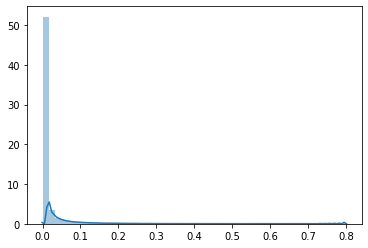

In [ ]:
import seaborn as sns
sns.distplot(pre)